In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import trange

import pymc as pm

from pymc_extras.inference.advi.autoguide import AutoDiagonalNormal
from pymc_extras.inference.advi.training import compile_svi_training_fn

In [2]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 3))
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 5, size=(3,))

    mu = alpha + X @ beta
    sigma = pm.HalfNormal("sigma", 1)
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive(random_seed=38)

Sampling: [X, alpha, beta, sigma, y]


In [3]:
draw = 123
true_params = {}
true_params["alpha"] = prior.prior.alpha.sel(chain=0, draw=draw).values
true_params["beta"] = prior.prior.beta.sel(chain=0, draw=draw).values
true_params["sigma"] = prior.prior.sigma.sel(chain=0, draw=draw).values

X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [4]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

In [5]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [6]:
with m_obs:
    idata = pm.sample(mp_ctx="spawn")

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [7]:
guide = AutoDiagonalNormal(m_obs)

In [8]:
guide.params_init_values

{sigma_loc: array(0.26284188),
 sigma_scale: array(0.1),
 beta_loc: array([0.88503108, 0.78157369, 0.67367489]),
 beta_scale: array([0.1, 0.1, 0.1]),
 alpha_loc: array(-0.5681205),
 alpha_scale: array(0.1)}

In [9]:
true_loc_dict = {k.name: v for k, v in guide.params_init_values.items()}
for key, value in true_params.items():
    true_loc_dict[f"{key}_loc"] = value
true_loc_dict

{'sigma_loc': array(0.40007044),
 'sigma_scale': array(0.1),
 'beta_loc': array([-0.92518728,  0.27270752, -0.20081106]),
 'beta_scale': array([0.1, 0.1, 0.1]),
 'alpha_loc': array(11.82213038),
 'alpha_scale': array(0.1)}

In [10]:
f_loss_dloss = compile_svi_training_fn(m_obs, guide, stick_the_landing=True)

In [11]:
f_loss_dloss(np.array(500), **true_loc_dict)

[array(264.54163996),
 array(-141.54734769),
 array(151.88467924),
 array([-7.95708067, -4.35176788, -1.4180619 ]),
 array([45.02632721, 44.46560167, 31.55529906]),
 array(15.40696434),
 array(43.45550916)]

In [12]:
init_param_values = {k.name: v for k, v in guide.params_init_values.items()}
opt_param_values = list(init_param_values.values())
learning_rate = 1e-5
n_iter = 2_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(500, dtype=int)
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]
    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.2f}")
    if i % 5_000 == 0 and i > 0:
        learning_rate = max(learning_rate / 5, 1e-5)

optimized_params = dict(zip(init_param_values, opt_param_values))

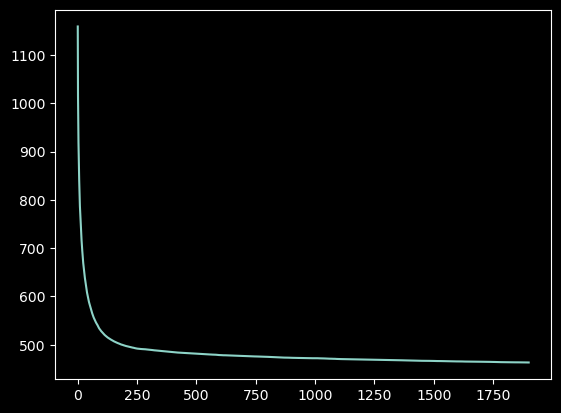

In [13]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [14]:
n_iter = 2_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(500, dtype=int)
learning_rate = 1e-3
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    if any(np.isnan(d_loss).any() for d_loss in grads):
        print("Got nan, getting out")
        break
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]

    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.3f}")

optimized_params = dict(zip(init_param_values, opt_param_values))
optimized_params

{'sigma_loc': array(-1.08338307),
 'sigma_scale': array(-3.40979122),
 'beta_loc': array([-0.90914275,  0.27361567, -0.15888119]),
 'beta_scale': array([-3.82559357, -3.84190526, -3.72892214]),
 'alpha_loc': array(11.78181088),
 'alpha_scale': array(-3.84125139)}

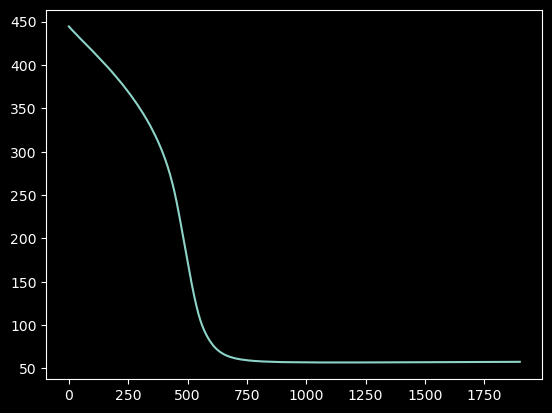

In [15]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [16]:
true_params["beta"]

array([-0.92518728,  0.27270752, -0.20081106])

In [17]:
f_loss_dloss(np.array(500), **true_loc_dict)

[array(315.55632031),
 array(-230.91497151),
 array(302.6189981),
 array([-3.98004556,  6.85857563, -9.27823392]),
 array([43.40893142, 64.50616261, 59.40050354]),
 array(18.76786789),
 array(59.22616729)]

In [18]:
f_loss_dloss(np.array(500, dtype=int), *opt_param_values)

[array(57.63612282),
 array(-0.29440051),
 array(0.21724758),
 array([ 1.01318409, -0.01027799,  1.15720638]),
 array([0.39221349, 0.37674832, 0.41073372]),
 array(0.27247629),
 array(0.38035044)]

In [19]:
def inverse_softplus(x):
    return np.log(np.expm1(x))


mcmc_param_values = {}
mcmc_param_values["sigma_loc"] = np.log(idata.posterior["sigma"]).mean(("chain", "draw")).values
mcmc_param_values["sigma_scale"] = inverse_softplus(
    np.log(idata.posterior["sigma"]).std(("chain", "draw"))
).values

for param in ("beta", "alpha"):
    mcmc_param_values[f"{param}_loc"] = idata.posterior[param].mean(("chain", "draw")).values
    mcmc_param_values[f"{param}_scale"] = inverse_softplus(
        idata.posterior[param].std(("chain", "draw"))
    ).values

In [20]:
optimized_params

{'sigma_loc': array(-1.08338307),
 'sigma_scale': array(-3.40979122),
 'beta_loc': array([-0.90914275,  0.27361567, -0.15888119]),
 'beta_scale': array([-3.82559357, -3.84190526, -3.72892214]),
 'alpha_loc': array(11.78181088),
 'alpha_scale': array(-3.84125139)}

In [21]:
mcmc_param_values

{'sigma_loc': array(-1.06794148),
 'sigma_scale': array(-2.57880694),
 'beta_loc': array([-0.90863733,  0.27245212, -0.15930082]),
 'beta_scale': array([-3.29214417, -3.33548593, -3.19476947]),
 'alpha_loc': array(11.78181598),
 'alpha_scale': array(-3.31635547)}

In [22]:
f_loss_dloss(np.array(500, dtype=int), **mcmc_param_values)

[array(56.62881272),
 array(-1.36239183),
 array(1.0238659),
 array([ 1.15112757, -1.83769092, -1.2189314 ]),
 array([1.16681203, 1.04059241, 1.2233972 ]),
 array(2.14756573),
 array(1.07150661)]

## Todo:

- Does this "two models" frameworks fits into what we already have?
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...